### Convolutional neural network using Tensorflow Functional API
<br><br />
This exercise is to implement a CNN which is very similar to the *LeNet-5* network made to identify hand written digits from the [MNIST database](http://yann.lecun.com/exdb/mnist/). The database was converted to a matlab file externally and imported as it is here.

Here *Tensorflow* data.Dataset API is also used to create a training dataset much like you would do on cloud for a data pipeline.<br><br />

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

MNIST database example digit:  3


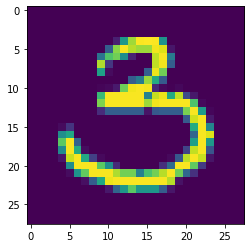

In [4]:
d = sio.loadmat("mnist.mat")

# -- 60,000 training samples --
im_data = d['trainX']  # (60000, 784) -- images
lb_data = d['trainY']  # (1, 60000) -- labels

im, im_val, lb, lb_val = train_test_split(im_data, 
                                          lb_data.reshape(-1,), 
                                          test_size=0.1, 
                                          random_state=50)


# -- 10,000 test samples --
im_test = d['testX']  # (10000, 784) -- test images
lb_test = d['testY']  # (1, 10000) -- test labels

n = np.random.randint(0,high=len(im))

# -- labelled sample from dataset --
print('MNIST database example digit: ', lb[n])
plt.imshow(im[n].reshape(28,28))
plt.show()

In [5]:
print(im.shape)
print(im_val.shape)

(54000, 784)
(6000, 784)


In [6]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
tf.__version__

'2.3.0'

In [7]:
## -- CNN model architecture using TF Functional API --

# -- input layer
in_put = tf.keras.Input(shape=(28,28,1), name='input_layer')
# -- 2D conv layer
im_conv1 = tf.keras.layers.Conv2D( name = 'conv1',
    filters=32,
    kernel_size=5,
    activation='relu',
    padding='same'
)(in_put)
# -- max pooling layer
pool1 = tf.keras.layers.MaxPool2D( name = 'pool1',
    pool_size=(2, 2),
)(im_conv1)

# -- 2D conv layer
im_conv2 = tf.keras.layers.Conv2D( name = 'conv2',
    filters=64,
    kernel_size=5,
    activation='relu',
#     padding='same'
)(pool1)
# -- max pooling layer
pool2 = tf.keras.layers.MaxPool2D( name = 'pool2',
    pool_size=(2, 2),
)(im_conv2)

# -- dense layers
flat = tf.keras.layers.Flatten(name='flat1')(pool2)
a = tf.keras.layers.Dense(240, activation='relu', name='dense1')(flat)
# b = tf.keras.layers.Dense(80, activation='relu', name='dense3')(a)
output = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(a)

model = tf.keras.Model(in_put, output)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 64)        51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 5, 64)          0         
_________________________________________________________________
flat1 (Flatten)              (None, 1600)              0         
_________________________________________________________________
dense1 (Dense)               (None, 240)              

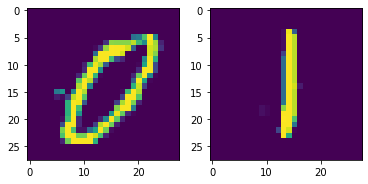

In [11]:
## -- creating datasets using TF Dataset API --

BATCH_SIZE = 50
dataset = tf.data.Dataset.from_tensor_slices(((im/255.).reshape(-1,28,28,1), 
                                              to_categorical(lb.reshape(-1,1))))

dataset = dataset.shuffle(len(im), reshuffle_each_iteration=True).batch(BATCH_SIZE)

# -- validation set --
valset = tf.data.Dataset.from_tensor_slices(((im_val/255.).reshape(-1,28,28,1), 
                                              to_categorical(lb_val.reshape(-1,1))))
valset = valset.batch(4)

# -- plotting two examples from the shuffled dataset
fig, axes = plt.subplots(ncols=2, nrows=1)
for n,i in enumerate(dataset.take(2)):
    axes[n].imshow(i[0][0])
plt.show()

testset = tf.data.Dataset.from_tensor_slices(((im_test/255.).reshape(-1,28,28,1), 
                                              to_categorical(lb_test.reshape(-1,1)))).batch(1)

In [12]:
print(valset.take(1))
print(dataset.take(1))
print(testset.take(1))

<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float64, tf.float32)>
<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float64, tf.float32)>
<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float64, tf.float32)>


In [13]:
## -- compiling and training the model --
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

history = model.fit(dataset, 
                   epochs=4,
                   validation_data=valset,
                   )

Epoch 1/4
1080/1080 [==============================] - 44s 41ms/step - loss: 0.1242 - accuracy: 0.9624 - val_loss: 0.0455 - val_accuracy: 0.9865
Epoch 2/4
1080/1080 [==============================] - 48s 44ms/step - loss: 0.0389 - accuracy: 0.9880 - val_loss: 0.0494 - val_accuracy: 0.9842
Epoch 3/4
1080/1080 [==============================] - 46s 42ms/step - loss: 0.0254 - accuracy: 0.9914 - val_loss: 0.0459 - val_accuracy: 0.9872
Epoch 4/4
1080/1080 [==============================] - 46s 43ms/step - loss: 0.0195 - accuracy: 0.9939 - val_loss: 0.0346 - val_accuracy: 0.9890


In [14]:
## -- evaluating the model with test data --

[loss, acc] = model.evaluate(testset)
print(f'Accuracy on test data: {round(acc*100,1)} %')

10000/10000 [==============================] - 15s 1ms/step - loss: 0.0300 - accuracy: 0.9901 0s - l
Accuracy on test data: 99.0 %


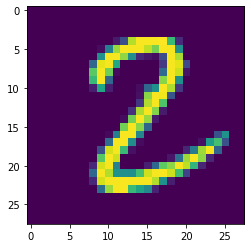

Answer: 2


In [34]:
## -- random output prediction --

n = np.random.randint(0,high=10000)

x = np.array(im_test[n]/255)
x = x.reshape(-1,28,28,1)

plt.imshow(x[0])
plt.show()

print(f'Answer: {np.argmax(model.predict(x))}')

In [35]:
## -- getting filter output from first convolution layer --
layer_name = 'conv1'
intm_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intm_output = intm_layer_model(x)

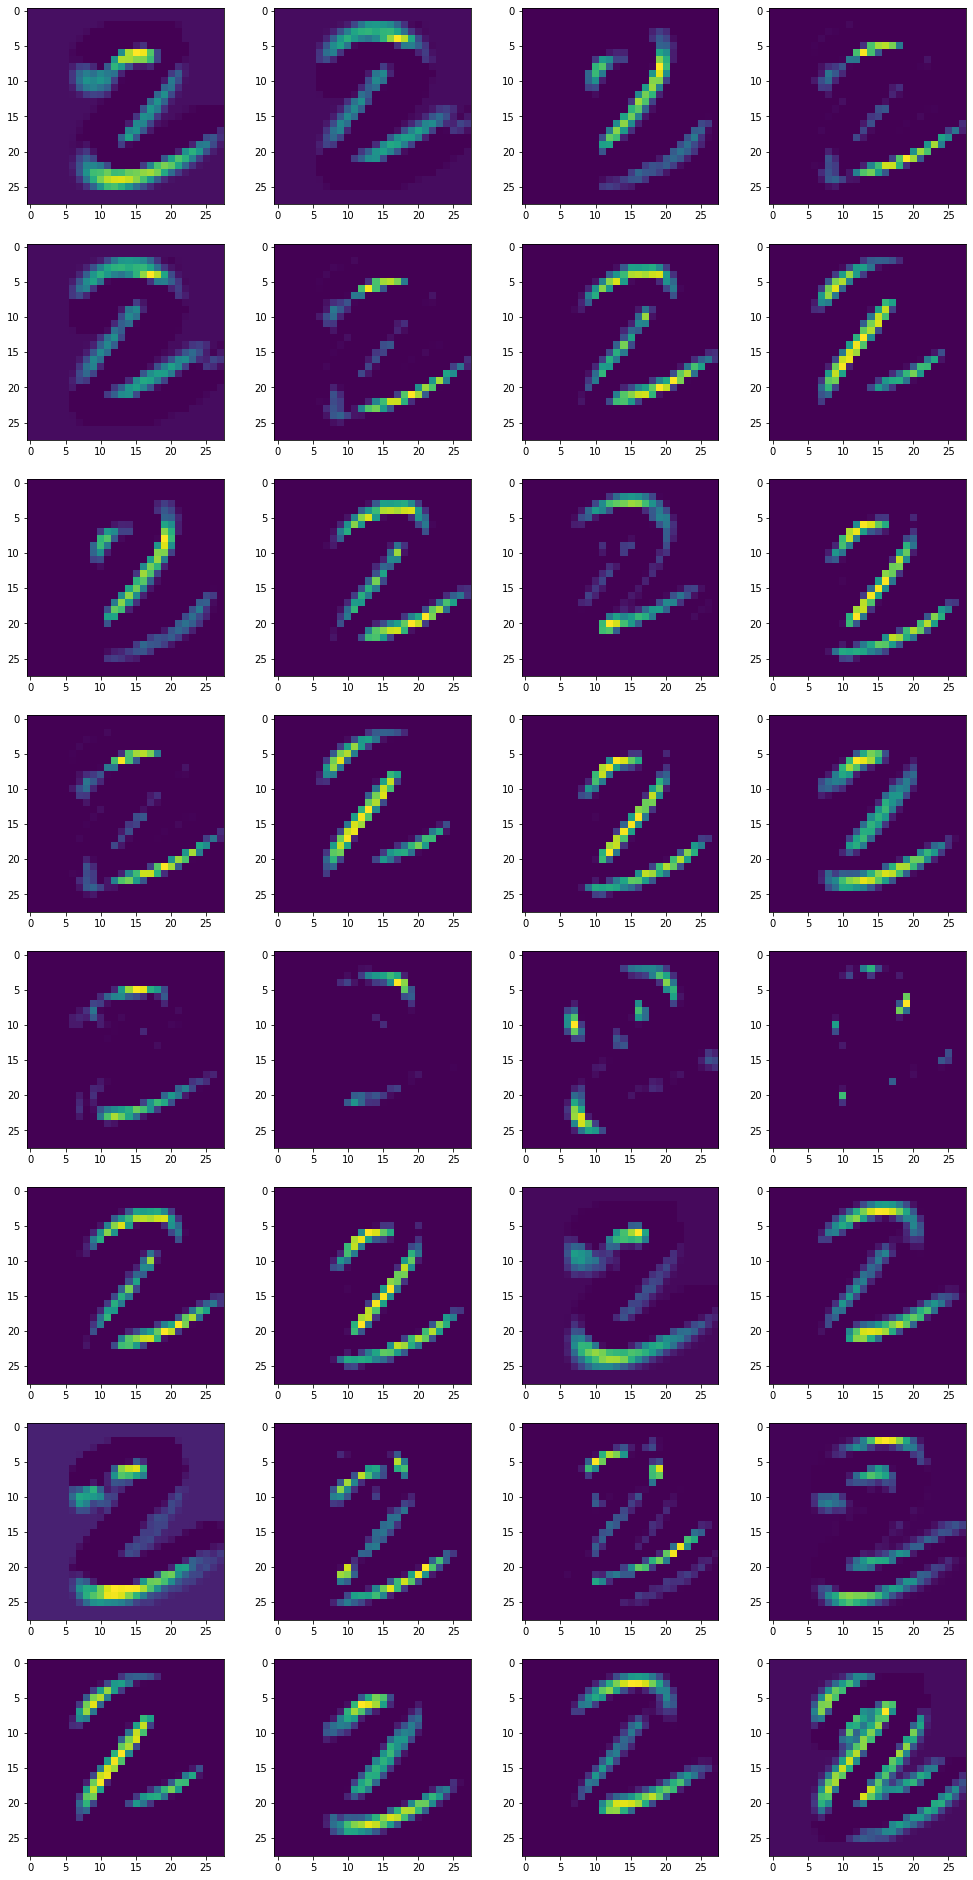

In [39]:
# -- plotting 1st convolutional layer features --

cols = 4
rows = 8
fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(17,34))
for i in range(rows):
    for j in range(cols):
        axes[i,j].imshow(intm_output[0][:,:,(i+1)*(j+1)-1])
plt.show()